<a href="https://colab.research.google.com/github/GoogleCloudPlatform/tensorflow-without-a-phd/blob/master/tensorflow-rnn-tutorial/00_Keras_RNN_predictions_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# An RNN for short-term predictions
This model will try to predict the next value in a short sequence based on historical data. This can be used for example to forecast demand based on a couple of weeks of sales data. This is the solution notebook. The corresponding work notebook is here: [00_Keras_RNN_predictions_playground.ipynb](https://colab.research.google.com/github/GoogleCloudPlatform/tensorflow-without-a-phd/blob/master/tensorflow-rnn-tutorial/00_Keras_RNN_predictions_playground.ipynb)

In [0]:
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
tf.enable_eager_execution()
print("Tensorflow version: " + tf.__version__)

In [0]:
#@title Display utilities [RUN ME]

from enum import IntEnum
import numpy as np

class Waveforms(IntEnum):
    SINE1 = 0
    SINE2 = 1
    SINE3 = 2
    SINE4 = 3

def create_time_series(waveform, datalen):
    # Generates a sequence of length datalen
    # There are three available waveforms in the Waveforms enum
    # good waveforms
    frequencies = [(0.2, 0.15), (0.35, 0.3), (0.6, 0.55), (0.4, 0.25)]
    freq1, freq2 = frequencies[waveform]
    noise = [np.random.random()*0.2 for i in range(datalen)]
    x1 = np.sin(np.arange(0,datalen) * freq1)  + noise
    x2 = np.sin(np.arange(0,datalen) * freq2)  + noise
    x = x1 + x2
    return x.astype(np.float32)

from matplotlib import transforms as plttrans

plt.rcParams['figure.figsize']=(16.8,6.0)
plt.rcParams['axes.grid']=True
plt.rcParams['axes.linewidth']=0
plt.rcParams['grid.color']='#DDDDDD'
plt.rcParams['axes.facecolor']='white'
plt.rcParams['xtick.major.size']=0
plt.rcParams['ytick.major.size']=0

def picture_this_1(data, datalen):
    plt.subplot(211)
    plt.plot(data[datalen-512:datalen+512])
    plt.axvspan(0, 512, color='black', alpha=0.06)
    plt.axvspan(512, 1024, color='grey', alpha=0.04)
    plt.subplot(212)
    plt.plot(data[3*datalen-512:3*datalen+512])
    plt.axvspan(0, 512, color='grey', alpha=0.04)
    plt.axvspan(512, 1024, color='black', alpha=0.06)
    plt.show()
    
def picture_this_2(data, batchsize, seqlen):
    samples = np.reshape(data, [-1, batchsize, seqlen])
    rndsample = samples[np.random.choice(samples.shape[0], 8, replace=False)]
    print("Tensor shape of a batch of training sequences: " + str(rndsample[0].shape))
    print("Random excerpt:")
    subplot = 241
    for i in range(8):
        plt.subplot(subplot)
        plt.plot(rndsample[i, 0]) # first sequence in random batch
        subplot += 1
    plt.show()
    
def picture_this_3(predictions, evaldata, evallabels, seqlen):
    subplot = 241
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    for i in range(8):
        plt.subplot(subplot)
        #k = int(np.random.rand() * evaldata.shape[0])
        l0, = plt.plot(evaldata[i, 1:], label="data")
        plt.plot([seqlen-2, seqlen-1], evallabels[i, -2:])
        l1, = plt.plot([seqlen-1], [predictions[i]], "o", color="red", label='Predicted')
        l2, = plt.plot([seqlen-1], [evallabels[i][-1]], "o", color=colors[1], label='Ground Truth')
        if i==0:
            plt.legend(handles=[l0, l1, l2])
        subplot += 1
    plt.show()
    
def picture_this_hist(rmse1, rmse2, rmse3, rmse):
  colors = ['#4285f4', '#34a853', '#fbbc05', '#ea4334']
  plt.figure(figsize=(5,4))
  plt.xticks(rotation='40')
  plt.title('RMSE: your model vs. simplistic approaches')
  plt.bar(['RND', 'LAST', 'LAST2', 'Yours'], [rmse1, rmse2, rmse3, rmse], color=colors)
  plt.show()

def picture_this_hist_all(rmse1, rmse2, rmse3, rmse4, rmse5, rmse6, rmse7, rmse8):
  colors = ['#4285f4', '#34a853', '#fbbc05', '#ea4334', '#4285f4', '#34a853', '#fbbc05', '#ea4334']
  plt.figure(figsize=(7,4))
  plt.xticks(rotation='40')
  plt.ylim(0, 0.35)
  plt.title('RMSE: all models')
  plt.bar(['RND', 'LAST', 'LAST2', 'LINEAR', 'DNN', 'CNN', 'RNN', 'RNN_N'],
          [rmse1, rmse2, rmse3, rmse4, rmse5, rmse6, rmse7, rmse8], color=colors)
  plt.show()

## Generate fake dataset

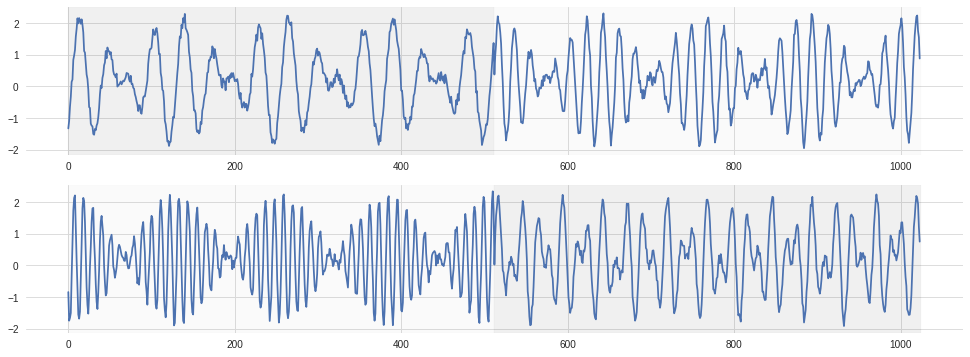

In [3]:
DATA_SEQ_LEN = 1024*128
data = np.concatenate([create_time_series(waveform, DATA_SEQ_LEN) for waveform in Waveforms]) # 4 different wave forms
picture_this_1(data, DATA_SEQ_LEN)
DATA_LEN = DATA_SEQ_LEN * 4 # since we concatenated 4 sequences

## Hyperparameters

In [0]:
RNN_CELLSIZE = 32   # size of the RNN cells
SEQLEN = 16         # unrolled sequence length
BATCHSIZE = 32      # mini-batch size
LAST_N = SEQLEN//2  # loss computed on last N element of sequence in advanced RNN model

## Visualize training sequences
This is what the neural network will see during training.

Tensor shape of a batch of training sequences: (32, 16)
Random excerpt:


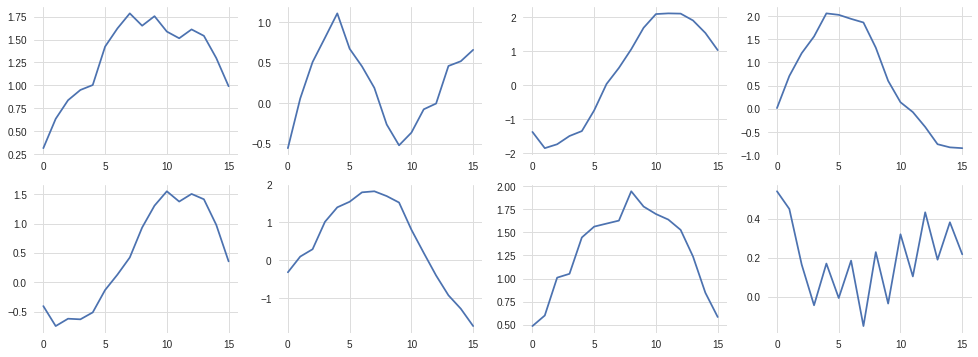

In [5]:
picture_this_2(data, BATCHSIZE, SEQLEN) # execute multiple times to see different sample sequences

## Benchmark model definitions
We will compare the RNNs against these models. For the time being you can regard them as black boxes.

In [0]:
# this is how to create a Keras model from neural network layers
def compile_keras_sequential_model(list_of_layers, msg):
  
    # a tf.keras.Sequential model is a sequence of layers
    model = tf.keras.Sequential(list_of_layers)
    
    # keras does not have a pre-defined metric for Root Mean Square Error. Let's define one.
    def rmse(y_true, y_pred): # Root Mean Squared Error
      return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))
    
    print('\nModel ', msg)
    
    # to finalize the model, specify the loss, the optimizer and metrics
    model.compile(
       loss = 'mean_squared_error',
       optimizer = 'rmsprop',
       metrics = [rmse])
    
    # this prints a description of the model
    model.summary()
    
    return model
  
#
# three very simplistic "models" that require no training. Can you beat them ?
#

# SIMPLISTIC BENCHMARK MODEL 1
predict_same_as_last_value = lambda x: x[:,-1] # shape of x is [BATCHSIZE,SEQLEN]
# SIMPLISTIC BENCHMARK MODEL 2
predict_trend_from_last_two_values = lambda x: x[:,-1] + (x[:,-1] - x[:,-2])
# SIMPLISTIC BENCHMARK MODEL 3
predict_random_value = lambda x: tf.random.uniform(tf.shape(x)[0:1], -2.0, 2.0)

def model_layers_from_lambda(lambda_fn, input_shape, output_shape):
  return [tf.keras.layers.Lambda(lambda_fn, input_shape=input_shape),
          tf.keras.layers.Reshape(output_shape)]

model_layers_RAND  = model_layers_from_lambda(predict_random_value,               input_shape=[SEQLEN,], output_shape=[1,])
model_layers_LAST  = model_layers_from_lambda(predict_same_as_last_value,         input_shape=[SEQLEN,], output_shape=[1,])
model_layers_LAST2 = model_layers_from_lambda(predict_trend_from_last_two_values, input_shape=[SEQLEN,], output_shape=[1,])

#
# three neural network models for comparison, in increasing order of complexity
#

l = tf.keras.layers  # syntax shortcut

# BENCHMARK MODEL 4: linear model (RMSE: 0.215 after 10 epochs)
model_layers_LINEAR = [l.Dense(1, input_shape=[SEQLEN,])] # output shape [BATCHSIZE, 1]

# BENCHMARK MODEL 5: 2-layer dense model (RMSE: 0.197 after 10 epochs)
model_layers_DNN = [l.Dense(SEQLEN//2, activation='relu', input_shape=[SEQLEN,]), # input  shape [BATCHSIZE, SEQLEN]
                    l.Dense(1)] # output shape [BATCHSIZE, 1]

# BENCHMARK MODEL 6: convolutional (RMSE: 0.186 after 10 epochs)
model_layers_CNN = [
    l.Reshape([SEQLEN, 1], input_shape=[SEQLEN,]), # [BATCHSIZE, SEQLEN, 1] is necessary for conv model
    l.Conv1D(filters=8, kernel_size=4, activation='relu', padding="same"), # [BATCHSIZE, SEQLEN, 8]
    l.Conv1D(filters=16, kernel_size=3, activation='relu', padding="same"), # [BATCHSIZE, SEQLEN, 8]
    l.Conv1D(filters=8, kernel_size=1, activation='relu', padding="same"), # [BATCHSIZE, SEQLEN, 8]
    l.MaxPooling1D(pool_size=2, strides=2),  # [BATCHSIZE, SEQLEN//2, 8]
    l.Conv1D(filters=8, kernel_size=3, activation='relu', padding="same"),  # [BATCHSIZE, SEQLEN//2, 8]
    l.MaxPooling1D(pool_size=2, strides=2),  # [BATCHSIZE, SEQLEN//4, 8]
    # mis-using a conv layer as linear regression :-)
    l.Conv1D(filters=1, kernel_size=SEQLEN//4, activation=None, padding="valid"), # output shape [BATCHSIZE, 1, 1]
    l.Reshape([1,]) ] # output shape [BATCHSIZE, 1]

In [7]:
# instantiate the benchmark models
model_RAND   = compile_keras_sequential_model(model_layers_RAND, "RAND")
model_LAST   = compile_keras_sequential_model(model_layers_LAST, "LAST")
model_LAST2  = compile_keras_sequential_model(model_layers_LAST2, "LAST2")
model_LINEAR = compile_keras_sequential_model(model_layers_LINEAR, "LINEAR")
model_DNN    = compile_keras_sequential_model(model_layers_DNN, "DNN")
model_CNN    = compile_keras_sequential_model(model_layers_CNN, "CNN")


Model  RAND
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None,)                   0         
_________________________________________________________________
reshape (Reshape)            (None, 1)                 0         
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________

Model  LAST
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None,)                   0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 1)                 0         
Total params: 0
Trainable params: 0
Non-trainable params: 0
________

## Prepare datasets

In [0]:
# training to predict the same sequence shifted by one (next value)
labeldata = np.roll(data, -1)

# cut data into sequences
traindata = np.reshape(data, [-1, SEQLEN])
labeldata = np.reshape(labeldata, [-1, SEQLEN])

# make an evaluation dataset by cutting the sequences differently
evaldata = np.roll(data, -SEQLEN//2)
evallabels = np.roll(evaldata, -1)
evaldata = np.reshape(evaldata, [-1, SEQLEN])
evallabels = np.reshape(evallabels, [-1, SEQLEN])

def get_training_dataset(last_n=1):
  dataset = tf.data.Dataset.from_tensor_slices(
      (
          traindata, # features
          labeldata[:,-last_n:SEQLEN] # targets: the last element or last n elements in the shifted sequence
      )
  )
  # Dataset API used here to put the dataset into shape
  dataset = dataset.repeat()
  dataset = dataset.shuffle(DATA_LEN//SEQLEN) # shuffling is important ! (Number of sequences in shuffle buffer: all of them)
  dataset = dataset.batch(BATCHSIZE, drop_remainder = True)
  return dataset

def get_evaluation_dataset(last_n=1):
  dataset = tf.data.Dataset.from_tensor_slices(
      (
          evaldata, # features       
          evallabels[:,-last_n:SEQLEN] # targets: the last element or last n elements in the shifted sequence
      )
  )
  # Dataset API used here to put the dataset into shape
  dataset = dataset.batch(evaldata.shape[0], drop_remainder = True) # just one batch with everything
  return dataset

### Peek at the data

In [9]:
train_ds = get_training_dataset()
for features, labels in train_ds.take(10):
  print("input_shape:", features.numpy().shape, ", shape of labels:", labels.numpy().shape)

input_shape: (32, 16) , shape of labels: (32, 1)
input_shape: (32, 16) , shape of labels: (32, 1)
input_shape: (32, 16) , shape of labels: (32, 1)
input_shape: (32, 16) , shape of labels: (32, 1)
input_shape: (32, 16) , shape of labels: (32, 1)
input_shape: (32, 16) , shape of labels: (32, 1)
input_shape: (32, 16) , shape of labels: (32, 1)
input_shape: (32, 16) , shape of labels: (32, 1)
input_shape: (32, 16) , shape of labels: (32, 1)
input_shape: (32, 16) , shape of labels: (32, 1)


## RNN models

![deep RNN schematic](https://googlecloudplatform.github.io/tensorflow-without-a-phd/images/RNN1.svg)
<div style="text-align: right; font-family: monospace">
  X shape [BATCHSIZE, SEQLEN, 1]<br/>
  Y shape [BATCHSIZE, SEQLEN, 1]<br/>
  H shape [BATCHSIZE, RNN_CELLSIZE*N_LAYERS]
</div>

In [10]:
# RNN model (RMSE: 0.164 after 10 epochs)
model_layers_RNN = [
    l.Reshape([SEQLEN, 1], input_shape=[SEQLEN,]), # [BATCHSIZE, SEQLEN, 1] is necessary for RNN model
    l.GRU(RNN_CELLSIZE, return_sequences=True),  # output shape [BATCHSIZE, SEQLEN, RNN_CELLSIZE]
    l.GRU(RNN_CELLSIZE), # keep only last output in sequence: output shape [BATCHSIZE, RNN_CELLSIZE]
    l.Dense(1) # output shape [BATCHSIZE, 1]
]

model_RNN = compile_keras_sequential_model(model_layers_RNN, "RNN")


Model  RNN
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_5 (Reshape)          (None, 16, 1)             0         
_________________________________________________________________
gru (GRU)                    (None, 16, 32)            3264      
_________________________________________________________________
gru_1 (GRU)                  (None, 32)                6240      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 9,537
Trainable params: 9,537
Non-trainable params: 0
_________________________________________________________________


In [11]:
# RNN model with loss computed on last N elements (RMSE: 0.163 after 10 epochs)
model_layers_RNN_N = [
    l.Reshape([SEQLEN, 1], input_shape=[SEQLEN,]), # [BATCHSIZE, SEQLEN, 1] is necessary for RNN model
    l.GRU(RNN_CELLSIZE, return_sequences=True),
    l.GRU(RNN_CELLSIZE, return_sequences=True), # output shape [BATCHSIZE, SEQLEN, RNN_CELLSIZE]
    l.TimeDistributed(l.Dense(1)),              # output shape [BATCHSIZE, SEQLEN, 1]
    l.Lambda(lambda x: x[:,-LAST_N:SEQLEN,0]) # last N item(s) in sequence: output shape [BATCHSIZE, LAST_N]
]

model_RNN_N = compile_keras_sequential_model(model_layers_RNN_N, 'RNN_N')


Model  RNN_N
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_6 (Reshape)          (None, 16, 1)             0         
_________________________________________________________________
gru_2 (GRU)                  (None, 16, 32)            3264      
_________________________________________________________________
gru_3 (GRU)                  (None, 16, 32)            6240      
_________________________________________________________________
time_distributed (TimeDistri (None, 16, 1)             33        
_________________________________________________________________
lambda_3 (Lambda)            (None, 8)                 0         
Total params: 9,537
Trainable params: 9,537
Non-trainable params: 0
_________________________________________________________________


## Training loop

In [12]:
# You can re-execute this cell to continue training

NB_EPOCHS = 3      # number of times the data is repeated during training
steps_per_epoch = DATA_LEN // SEQLEN // BATCHSIZE

model = model_RNN_N # model to train: model_LINEAR, model_DNN, model_CNN, model_RNN, model_RNN_N
train_ds = get_training_dataset(last_n=LAST_N) # use last_n=LAST_N for model_RNN_N

history = model.fit(train_ds, steps_per_epoch=steps_per_epoch, epochs=NB_EPOCHS)

Epoch 1/3
Instructions for updating:
Use tf.cast instead.
1024/1024 [==============================] - 23s 22ms/step - loss: 0.0694 - rmse: 0.2428
Epoch 2/3
1024/1024 [==============================] - 20s 19ms/step - loss: 0.0394 - rmse: 0.1982
Epoch 3/3
1024/1024 [==============================] - 19s 19ms/step - loss: 0.0375 - rmse: 0.1935


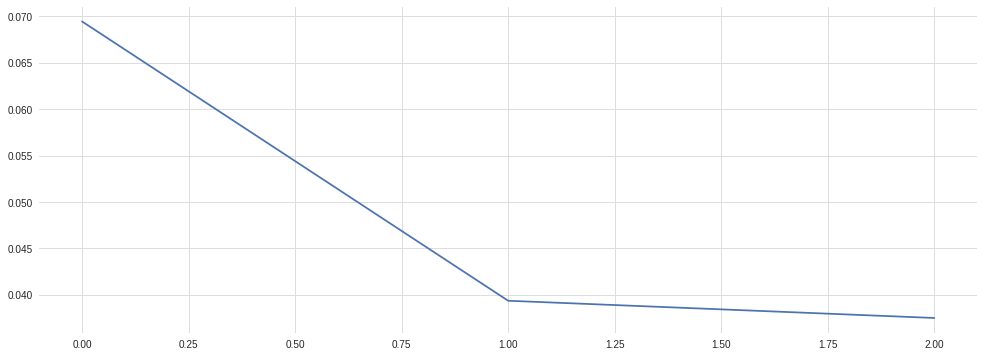

In [13]:
plt.plot(history.history['loss'])
plt.show()

## Evaluation

1/1 [==============================] - 2s 2s/step - loss: 0.0380 - rmse: 0.1949


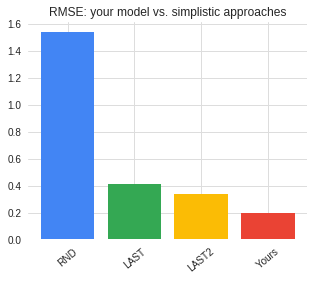

In [14]:
# Here "evaluating" using the training dataset
eval_ds = get_evaluation_dataset(last_n=LAST_N) # use last_n=LAST_N for model_RNN_N
loss, rmse = model.evaluate(eval_ds, steps=1)

# compare agains simplistic benchmark models that require no training
ds = get_evaluation_dataset()
_, rmse1 = model_RAND.evaluate(get_evaluation_dataset(), steps=1, verbose=0)
_, rmse2 = model_LAST.evaluate(get_evaluation_dataset(), steps=1, verbose=0)
_, rmse3 = model_LAST2.evaluate(get_evaluation_dataset(), steps=1, verbose=0)

picture_this_hist(rmse1, rmse2, rmse3, rmse)

## Predictions

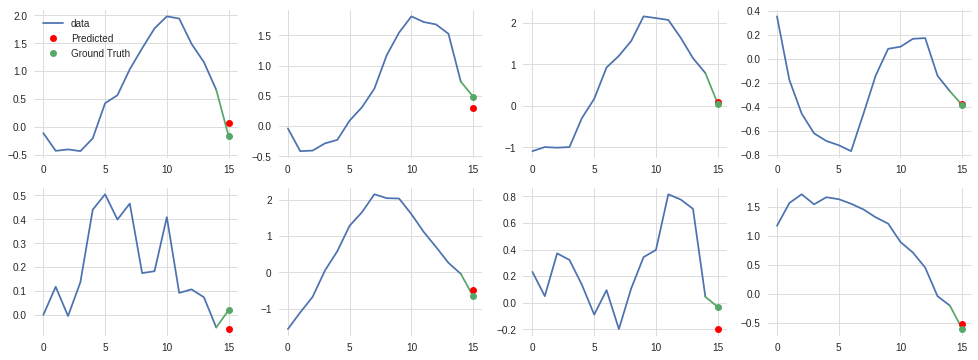

In [16]:
# execute multiple times to see different sample sequences
subset = np.random.choice(DATA_LEN//SEQLEN, 8) # pick 8 eval sequences at random

predictions = model.predict(evaldata[subset], steps=1) # prediction directly from numpy array
picture_this_3(predictions[:,-1], evaldata[subset], evallabels[subset], SEQLEN)

<a name="benchmark"></a>
## Benchmark
Benchmark all the algorithms. This takes a while (approx. 10 min).

In [0]:
# instantiate all models models again
model_RAND   = compile_keras_sequential_model(model_layers_RAND, "RAND")
model_LAST   = compile_keras_sequential_model(model_layers_LAST, "LAST")
model_LAST2  = compile_keras_sequential_model(model_layers_LAST2, "LAST2")
model_LINEAR = compile_keras_sequential_model(model_layers_LINEAR, "LINEAR")
model_DNN    = compile_keras_sequential_model(model_layers_DNN, "DNN")
model_CNN    = compile_keras_sequential_model(model_layers_CNN, "CNN")
model_RNN    = compile_keras_sequential_model(model_layers_RNN, "RNN")
model_RNN_N  = compile_keras_sequential_model(model_layers_RNN_N, 'RNN_N')

In [0]:
NB_EPOCHS = 10

# train all models
for i, model in enumerate([model_LINEAR, model_DNN, model_CNN, model_RNN]):
  print("Trainig ", ["model_LINEAR", "model_DNN", "model_CNN", "model_RNN"][i])
  model.fit(get_training_dataset(), steps_per_epoch=steps_per_epoch, epochs=NB_EPOCHS)

print("Training ", "model_RNN_N")
model_RNN_N.fit(get_training_dataset(last_n=LAST_N), steps_per_epoch=steps_per_epoch, epochs=NB_EPOCHS)

# evaluate all models
rmses = []
for model in [model_RAND, model_LAST, model_LAST2, model_LINEAR, model_DNN, model_CNN, model_RNN]:
  _, rmse = model.evaluate(get_evaluation_dataset(), steps=1)
  rmses.append(rmse)

_, rmse = model_RNN_N.evaluate(get_evaluation_dataset(last_n=LAST_N), steps=1)
rmses.append(rmse)

[1.5435231, 0.41145748, 0.33609793, 0.21479364, 0.196844, 0.1857681, 0.16368383, 0.16305003]


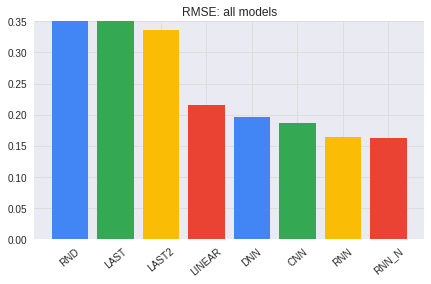

In [0]:
print(rmses)
picture_this_hist_all(*rmses)

Copyright 2019 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at
[http://www.apache.org/licenses/LICENSE-2.0](http://www.apache.org/licenses/LICENSE-2.0)
Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.